In [104]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
from sklearn.metrics import confusion_matrix

In [105]:
filter_size_1 = 5
num_filters_1 = 16

filter_size_2 = 5
num_filters_2 = 36

fc_size=128

In [106]:
from mnist import MNIST
data = MNIST(data_dir='data/MNIST/')

In [107]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [108]:
img_size = data.img_size
img_size_flat = data.img_size_flat
img_shape = data.img_shape
num_classes = data.num_classes
num_channels = data.num_channels
print(img_size)
print(num_channels)

28
1


In [109]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

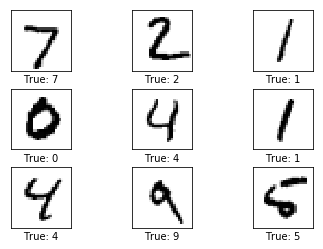

In [110]:
# Get the first images from the test-set.
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [111]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.05))

In [112]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05,shape=[length]))

In [113]:
def new_conv(input,
             num_input_channels,# prev layer
             filter_size,
             num_filters, # cur layer
             use_pooling = True):
    shape = [filter_size,filter_size,num_input_channels,num_filters]
    weights = new_weights(shape=shape)
    bias = new_biases(length=num_filters)
    
    layer = tf.nn.conv2d(input = input,
                     filter = weights,
                     strides = [1,1,1,1],
                     padding='SAME')
    
    layer+=bias
    
    if use_pooling:
        layer = tf.nn.max_pool(value = layer,
                               ksize = [1,2,2,1],
                               strides = [1,2,2,1],
                               padding='SAME')
        
    layer = tf.nn.relu(layer)
    return layer , weights

In [114]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer,[-1,num_features])
    return layer_flat,num_features

In [115]:
def new_fc_layer(input,
                 num_inputs,
                 num_outputs,
                 use_relu=True):
    weights = new_weights(shape=[num_inputs, num_outputs])
    bias = new_biases(length=num_outputs)
    layer = tf.matmul(input,weights)+bias
    if use_relu:
        return tf.nn.relu(layer)
    return layer
    

In [116]:
x = tf.placeholder(tf.float32,shape = [None,img_size_flat],name='x')
x_image = tf.reshape(x,[-1,img_size,img_size,num_channels])

In [117]:
y_true = tf.placeholder(tf.float32,shape=[None,num_classes],name='y_true')

In [118]:
y_true_cls = tf.argmax(y_true,axis=1)

In [119]:
layer_conv1 , weights_conv1 = new_conv(input = x_image,
                                      num_input_channels = num_channels,
                                      filter_size = filter_size_1,
                                      num_filters = num_filters_1)

In [120]:
layer_conv1

<tf.Tensor 'Relu_6:0' shape=(?, 14, 14, 16) dtype=float32>

In [121]:
layer_conv2 , weights_conv2 = new_conv(input = layer_conv1,
                                      num_input_channels = num_filters_1,
                                      filter_size = filter_size_2,
                                      num_filters = num_filters_2)

In [122]:
layer_conv2

<tf.Tensor 'Relu_7:0' shape=(?, 7, 7, 36) dtype=float32>

In [123]:
layer_flat,num_features = flatten_layer(layer_conv2)

In [124]:
layer_flat

<tf.Tensor 'Reshape_5:0' shape=(?, 1764) dtype=float32>

In [125]:
num_features

1764

In [126]:
layer_fc1=new_fc_layer(input=layer_flat,
                       num_inputs=num_features,
                       num_outputs=fc_size)

In [127]:
layer_fc1

<tf.Tensor 'Relu_8:0' shape=(?, 128) dtype=float32>

In [128]:
layer_fc2=new_fc_layer(input=layer_fc1,
                      num_inputs=fc_size,
                      num_outputs=num_classes,
                      use_relu=False)

In [129]:
layer_fc2

<tf.Tensor 'add_11:0' shape=(?, 10) dtype=float32>

In [130]:
y_pred=tf.nn.softmax(layer_fc2)

In [131]:
y_pred_cls=tf.argmax(y_pred,axis=1)

In [132]:
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                     labels=y_true)

we need scalar so we get the mean of entropy

In [133]:
cost=tf.reduce_mean(cross_entropy)

In [134]:
optimizer=tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [135]:
correct_prediction=tf.equal(y_true_cls,y_pred_cls)

In [136]:
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [137]:
session=tf.Session()
session.run(tf.global_variables_initializer())

In [138]:
train_batch_size=84

In [139]:
import time
total_iter = 0

def optimize(num_iter,optimizer):
    global total_iter
    start=time.time()
    for i in range(total_iter,total_iter+num_iter):
        x_batch,y_true_batch,_= data.random_batch(batch_size=train_batch_size)
        feed_dict_train={x:x_batch,
                        y_true:y_true_batch}
        session.run(optimizer,feed_dict=feed_dict_train)
        if i%100==0:
            acc=session.run(accuracy,feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))
    total_iter+=num_iter
    end=time.time()
    # Difference between start and end-times.
    time_dif = end-start

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [140]:
def plot_example_errors(cls_pred, correct):
    incorrect=(correct==False)
    images = data.x_test[incorrect]
    cls_pred=cls_pred[incorrect]
    cls_true=data.y_test_cls[incorrect]
    plot_images(images=images[:9],
               cls_true=cls_true[:9],
               cls_pred=cls_pred[:9])
    

In [141]:
def plot_confusion_matrix(cls_pred):
    cls_true=data.y_test_cls
    cm = confusion_matrix(y_true=cls_true,
                         y_pred=cls_pred)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    

In [142]:
import numpy as np
test_batch_size = 256

def print_acc(show_example_error=False,
              show_cm=False):
    num_test=data.num_test
    cls_pred=np.zeros(shape=num_test,dtype=np.int)
    i=0
    while i<num_test:
        j=min(i+test_batch_size,num_test)
        images=data.x_test[i:j,:]
        labels=data.y_test[i:j,:]
        feed_dict={
            x:images,
            y_true:labels
        }
        cls_pred[i:j]=session.run(y_pred_cls,feed_dict=feed_dict)
        i=j
    cls_true=data.y_test_cls
    correct = (cls_true==cls_pred)
    correct_sum = correct.sum()
    acc = correct_sum / num_test
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_error:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_cm:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [143]:
print_acc()

Accuracy on Test-Set: 11.8% (1177 / 10000)


In [144]:
optimize(num_iter=1,optimizer=optimizer)
print_acc()

Optimization Iteration:      1, Training Accuracy:  14.3%
Time usage: 0:00:00
Accuracy on Test-Set: 11.8% (1176 / 10000)


In [145]:
optimize(num_iter=99,optimizer=optimizer)
print_acc()

Time usage: 0:00:13
Accuracy on Test-Set: 64.6% (6457 / 10000)


In [146]:
optimize(num_iter=900,optimizer=optimizer) # total 1000
print_acc()

Optimization Iteration:    101, Training Accuracy:  59.5%
Optimization Iteration:    201, Training Accuracy:  77.4%
Optimization Iteration:    301, Training Accuracy:  88.1%
Optimization Iteration:    401, Training Accuracy:  86.9%
Optimization Iteration:    501, Training Accuracy:  90.5%
Optimization Iteration:    601, Training Accuracy:  92.9%
Optimization Iteration:    701, Training Accuracy:  89.3%
Optimization Iteration:    801, Training Accuracy:  91.7%
Optimization Iteration:    901, Training Accuracy:  91.7%
Time usage: 0:01:41
Accuracy on Test-Set: 93.5% (9349 / 10000)


Accuracy on Test-Set: 93.5% (9349 / 10000)
Example errors:


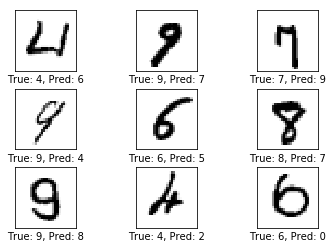

Confusion Matrix:


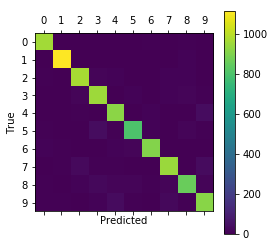

In [149]:
print_acc(show_example_error=True,
          show_cm=True)

Change Learning rate

In [153]:
for lr in [1e-4,0.001,0.01,0.1,0.9,0.99]:
    optimizer=tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    session.run(tf.global_variables_initializer())
    optimize(num_iter=200,optimizer=optimizer)
    print("Learning rate is {}".format(lr))
    print_acc()

Optimization Iteration:   2001, Training Accuracy:  15.5%
Optimization Iteration:   2101, Training Accuracy:  72.6%
Time usage: 0:00:22
Learning rate is 0.0001
Accuracy on Test-Set: 84.6% (8461 / 10000)
Optimization Iteration:   2201, Training Accuracy:  23.8%
Optimization Iteration:   2301, Training Accuracy:  94.0%
Time usage: 0:00:22
Learning rate is 0.001
Accuracy on Test-Set: 95.0% (9497 / 10000)
Optimization Iteration:   2401, Training Accuracy:  11.9%
Optimization Iteration:   2501, Training Accuracy:  10.7%
Time usage: 0:00:22
Learning rate is 0.01
Accuracy on Test-Set: 11.3% (1135 / 10000)
Optimization Iteration:   2601, Training Accuracy:  10.7%
Optimization Iteration:   2701, Training Accuracy:   8.3%
Time usage: 0:00:23
Learning rate is 0.1
Accuracy on Test-Set: 11.3% (1135 / 10000)
Optimization Iteration:   2801, Training Accuracy:  14.3%
Optimization Iteration:   2901, Training Accuracy:  14.3%
Time usage: 0:00:23
Learning rate is 0.9
Accuracy on Test-Set: 10.3% (1032 / 1

Change configurations

In [163]:
filter_size_1 = 5
num_filters_1 = 16
filter_size_2 = 5
num_filters_2 = 36
fc_size=128
layer_conv1 , weights_conv1 = new_conv(input = x_image,
                                      num_input_channels = num_channels,
                                      filter_size = filter_size_1,
                                      num_filters = num_filters_1)
layer_conv2 , weights_conv2 = new_conv(input = layer_conv1,
                                      num_input_channels = num_filters_1,
                                      filter_size = filter_size_2,
                                      num_filters = num_filters_2)
layer_flat,num_features = flatten_layer(layer_conv2)
layer_fc1=new_fc_layer(input=layer_flat,
                       num_inputs=num_features,
                       num_outputs=fc_size)
layer_fc2=new_fc_layer(input=layer_fc1,
                      num_inputs=fc_size,
                      num_outputs=num_classes,
                      use_relu=False)
y_pred=tf.nn.softmax(layer_fc2)
y_pred_cls=tf.argmax(y_pred,axis=1)
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                     labels=y_true)
cost=tf.reduce_mean(cross_entropy)
optimizer=tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction=tf.equal(y_true_cls,y_pred_cls)
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
session.run(tf.global_variables_initializer())
optimize(num_iter=200,optimizer=optimizer)
print_acc()

filter_size_1 = 5
num_filters_1 = 16
filter_size_2 = 5
num_filters_2 = 36
fc_size=256
layer_conv1 , weights_conv1 = new_conv(input = x_image,
                                      num_input_channels = num_channels,
                                      filter_size = filter_size_1,
                                      num_filters = num_filters_1)
layer_conv2 , weights_conv2 = new_conv(input = layer_conv1,
                                      num_input_channels = num_filters_1,
                                      filter_size = filter_size_2,
                                      num_filters = num_filters_2)
layer_flat,num_features = flatten_layer(layer_conv2)
layer_fc1=new_fc_layer(input=layer_flat,
                       num_inputs=num_features,
                       num_outputs=fc_size)
layer_fc2=new_fc_layer(input=layer_fc1,
                      num_inputs=fc_size,
                      num_outputs=num_classes,
                      use_relu=False)
y_pred=tf.nn.softmax(layer_fc2)
y_pred_cls=tf.argmax(y_pred,axis=1)
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                     labels=y_true)
cost=tf.reduce_mean(cross_entropy)
optimizer=tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction=tf.equal(y_true_cls,y_pred_cls)
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
session.run(tf.global_variables_initializer())
optimize(num_iter=200,optimizer=optimizer)
print_acc()

Optimization Iteration:   4001, Training Accuracy:  11.9%
Optimization Iteration:   4101, Training Accuracy:  63.1%
Time usage: 0:00:25
Accuracy on Test-Set: 82.4% (8236 / 10000)
Optimization Iteration:   4201, Training Accuracy:  11.9%
Optimization Iteration:   4301, Training Accuracy:  76.2%
Time usage: 0:00:25
Accuracy on Test-Set: 86.9% (8692 / 10000)


```
Test Resut:
    filter_size 3<5
    num_filters 32,64 > 16,36
    fc_size 128<256
```

In [167]:
filter_size_1 = 5
num_filters_1 = 16
filter_size_2 = 5
num_filters_2 = 36
fc_size=128
layer_conv1 , weights_conv1 = new_conv(input = x_image,
                                      num_input_channels = num_channels,
                                      filter_size = filter_size_1,
                                      num_filters = num_filters_1)
layer_conv2 , weights_conv2 = new_conv(input = layer_conv1,
                                      num_input_channels = num_filters_1,
                                      filter_size = filter_size_2,
                                      num_filters = num_filters_2)
layer_conv2 , weights_conv2 = new_conv(input = layer_conv2,
                                      num_input_channels = num_filters_2,
                                      filter_size = 5,
                                      num_filters = 56)
layer_flat,num_features = flatten_layer(layer_conv2)
layer_fc1=new_fc_layer(input=layer_flat,
                       num_inputs=num_features,
                       num_outputs=fc_size)
layer_fc1=tf.layers.dropout(layer_fc1,0.25)
layer_fc2=new_fc_layer(input=layer_fc1,
                      num_inputs=fc_size,
                      num_outputs=num_classes,
                      use_relu=False)

layer_fc2=tf.layers.dropout(layer_fc2,0.5)

y_pred=tf.nn.softmax(layer_fc2)
y_pred_cls=tf.argmax(y_pred,axis=1)
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                     labels=y_true)
cost=tf.reduce_mean(cross_entropy)
optimizer=tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction=tf.equal(y_true_cls,y_pred_cls)
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
session.run(tf.global_variables_initializer())
optimize(num_iter=200,optimizer=optimizer)
print_acc()


filter_size_1 = 5
num_filters_1 = 16
filter_size_2 = 5
num_filters_2 = 36
fc_size=128
layer_conv1 , weights_conv1 = new_conv(input = x_image,
                                      num_input_channels = num_channels,
                                      filter_size = filter_size_1,
                                      num_filters = num_filters_1)
layer_conv2 , weights_conv2 = new_conv(input = layer_conv1,
                                      num_input_channels = num_filters_1,
                                      filter_size = filter_size_2,
                                      num_filters = num_filters_2)
layer_flat,num_features = flatten_layer(layer_conv2)
layer_fc1=new_fc_layer(input=layer_flat,
                       num_inputs=num_features,
                       num_outputs=fc_size)
layer_fc1=tf.layers.dropout(layer_fc1,0.25)
layer_fc2=new_fc_layer(input=layer_fc1,
                      num_inputs=fc_size,
                      num_outputs=num_classes,
                      use_relu=False)

layer_fc2=tf.layers.dropout(layer_fc2,0.5)

y_pred=tf.nn.softmax(layer_fc2)
y_pred_cls=tf.argmax(y_pred,axis=1)
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                     labels=y_true)
cost=tf.reduce_mean(cross_entropy)
optimizer=tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction=tf.equal(y_true_cls,y_pred_cls)
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
session.run(tf.global_variables_initializer())
optimize(num_iter=200,optimizer=optimizer)
print_acc()

Optimization Iteration:   5201, Training Accuracy:   7.1%
Optimization Iteration:   5301, Training Accuracy:  69.0%
Time usage: 0:00:33
Accuracy on Test-Set: 82.2% (8225 / 10000)
Optimization Iteration:   5401, Training Accuracy:   9.5%
Optimization Iteration:   5501, Training Accuracy:  70.2%
Time usage: 0:00:23
Accuracy on Test-Set: 83.6% (8361 / 10000)


In [168]:
filter_size_1 = 5
num_filters_1 = 16
filter_size_2 = 5
num_filters_2 = 36
fc_size=128
layer_conv1 , weights_conv1 = new_conv(input = x_image,
                                      num_input_channels = num_channels,
                                      filter_size = filter_size_1,
                                      num_filters = num_filters_1)
layer_conv2 , weights_conv2 = new_conv(input = layer_conv1,
                                      num_input_channels = num_filters_1,
                                      filter_size = filter_size_2,
                                      num_filters = num_filters_2)
layer_conv2 , weights_conv2 = new_conv(input = layer_conv2,
                                      num_input_channels = num_filters_2,
                                      filter_size = 5,
                                      num_filters = 56)
layer_flat,num_features = flatten_layer(layer_conv2)
layer_fc1=new_fc_layer(input=layer_flat,
                       num_inputs=num_features,
                       num_outputs=fc_size)
layer_fc1=tf.layers.dropout(layer_fc1,0.25)
layer_fc2=new_fc_layer(input=layer_fc1,
                      num_inputs=fc_size,
                      num_outputs=num_classes,
                      use_relu=False)

layer_fc2=tf.layers.dropout(layer_fc2,0.5)

y_pred=tf.nn.softmax(layer_fc2)
y_pred_cls=tf.argmax(y_pred,axis=1)
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                     labels=y_true)
cost=tf.reduce_mean(cross_entropy)
optimizer=tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction=tf.equal(y_true_cls,y_pred_cls)
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
session.run(tf.global_variables_initializer())
optimize(num_iter=200,optimizer=optimizer)
print_acc()

filter_size_1 = 5
num_filters_1 = 16
filter_size_2 = 5
num_filters_2 = 36
fc_size=128
layer_conv1 , weights_conv1 = new_conv(input = x_image,
                                      num_input_channels = num_channels,
                                      filter_size = filter_size_1,
                                      num_filters = num_filters_1)
layer_conv2 , weights_conv2 = new_conv(input = layer_conv1,
                                      num_input_channels = num_filters_1,
                                      filter_size = filter_size_2,
                                      num_filters = num_filters_2)
layer_conv2 , weights_conv2 = new_conv(input = layer_conv2,
                                      num_input_channels = num_filters_2,
                                      filter_size = 5,
                                      num_filters = 56)
layer_flat,num_features = flatten_layer(layer_conv2)
layer_fc1=new_fc_layer(input=layer_flat,
                       num_inputs=num_features,
                       num_outputs=fc_size)
layer_fc1=tf.layers.dropout(layer_fc1,0.25)
layer_fc2=new_fc_layer(input=layer_fc1,
                      num_inputs=fc_size,
                      num_outputs=num_classes,
                      use_relu=True)

layer_fc2=tf.layers.dropout(layer_fc2,0.5)

y_pred=tf.nn.softmax(layer_fc2)
y_pred_cls=tf.argmax(y_pred,axis=1)
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                     labels=y_true)
cost=tf.reduce_mean(cross_entropy)
optimizer=tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction=tf.equal(y_true_cls,y_pred_cls)
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
session.run(tf.global_variables_initializer())
optimize(num_iter=200,optimizer=optimizer)
print_acc()


Optimization Iteration:   5601, Training Accuracy:  11.9%
Optimization Iteration:   5701, Training Accuracy:  58.3%
Time usage: 0:00:34
Accuracy on Test-Set: 84.1% (8408 / 10000)
Optimization Iteration:   5801, Training Accuracy:  14.3%
Optimization Iteration:   5901, Training Accuracy:  56.0%
Time usage: 0:00:33
Accuracy on Test-Set: 70.9% (7091 / 10000)


In [169]:
filter_size_1 = 5
num_filters_1 = 16
filter_size_2 = 5
num_filters_2 = 36
fc_size=128
layer_conv1 , weights_conv1 = new_conv(input = x_image,
                                      num_input_channels = num_channels,
                                      filter_size = filter_size_1,
                                      num_filters = num_filters_1,
                                      use_pooling=False)
layer_conv2 , weights_conv2 = new_conv(input = layer_conv1,
                                      num_input_channels = num_filters_1,
                                      filter_size = filter_size_2,
                                      num_filters = num_filters_2,
                                      use_pooling=False)
layer_flat,num_features = flatten_layer(layer_conv2)
layer_fc1=new_fc_layer(input=layer_flat,
                       num_inputs=num_features,
                       num_outputs=fc_size)
layer_fc1=tf.layers.dropout(layer_fc1,0.25)
layer_fc2=new_fc_layer(input=layer_fc1,
                      num_inputs=fc_size,
                      num_outputs=num_classes,
                      use_relu=False)

layer_fc2=tf.layers.dropout(layer_fc2,0.5)

y_pred=tf.nn.softmax(layer_fc2)
y_pred_cls=tf.argmax(y_pred,axis=1)
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                     labels=y_true)
cost=tf.reduce_mean(cross_entropy)
optimizer=tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction=tf.equal(y_true_cls,y_pred_cls)
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
session.run(tf.global_variables_initializer())
optimize(num_iter=200,optimizer=optimizer)
print_acc()


Optimization Iteration:   6001, Training Accuracy:  21.4%
Optimization Iteration:   6101, Training Accuracy:  81.0%
Time usage: 0:01:01
Accuracy on Test-Set: 89.2% (8923 / 10000)


`
use_max_pooling  False>True
last_fc_layer_use_relu True<False
`